In [5]:
import sys
import warnings
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../../../")))
warnings.filterwarnings("ignore")

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from einops import rearrange
from finetune.segment.chesapeake_datamodule import ChesapeakeDataModule
from finetune.segment.chesapeake_model import ChesapeakeSegmentor
from matplotlib.colors import ListedColormap

### Define paths and parameters

In [7]:
CHESAPEAKE_CHECKPOINT_PATH = (
    "../../../checkpoints/segment/multiclass_combined_loss_val-iou-0.7372.ckpt"
)
CLAY_CHECKPOINT_PATH = "../../../checkpoints/clay-v1.5.ckpt"
METADATA_PATH = "../../../configs/metadata.yaml"

TRAIN_CHIP_DIR = "../../../../dataset/ready/train/chips/"
TRAIN_LABEL_DIR = "../../../../dataset/ready/train/labels/"
VAL_CHIP_DIR = "../../../../dataset/ready/val/chips/"
VAL_LABEL_DIR = "../../../../dataset/ready/val/labels/"

BATCH_SIZE = 32
NUM_WORKERS = 1
PLATFORM = "sentinel-2-l2a-4band"
NUM_CLASSES = 2

In [8]:
chip = np.load(os.path.join(TRAIN_CHIP_DIR, os.listdir(TRAIN_CHIP_DIR)[0]))
print("Chip shape:", chip.shape)

Chip shape: (4, 224, 224)


### Model Loading

In [9]:
def get_model(chesapeake_checkpoint_path, clay_checkpoint_path, metadata_path, platform=None):
    model = ChesapeakeSegmentor.load_from_checkpoint(
        checkpoint_path=chesapeake_checkpoint_path,
        ckpt_path=clay_checkpoint_path,
        metadata_path=metadata_path,
    )
    # Set metadata and platform if not already set from checkpoint
    if platform is not None and (model.metadata is None or model.platform != platform):
        from box import Box
        import yaml
        with open(metadata_path, 'r') as f:
            model.metadata = Box(yaml.safe_load(f))
        model.platform = platform
    model.eval()
    return model

### Data Preparation

In [10]:
def get_data(
    train_chip_dir,
    train_label_dir,
    val_chip_dir,
    val_label_dir,
    metadata_path,
    batch_size,
    num_workers,
    platform,
    num_classes=None,
):
    dm = ChesapeakeDataModule(
        train_chip_dir=train_chip_dir,
        train_label_dir=train_label_dir,
        val_chip_dir=val_chip_dir,
        val_label_dir=val_label_dir,
        metadata_path=metadata_path,
        batch_size=batch_size,
        num_workers=num_workers,
        platform=platform,
        num_classes=num_classes,
    )
    dm.setup(stage="fit")
    val_dl = iter(dm.val_dataloader())
    batch = next(val_dl)
    metadata = dm.metadata
    return batch, metadata

### Prediction

In [11]:
def run_prediction(model, batch):
    with torch.no_grad():
        outputs = model(batch)
    outputs = F.interpolate(
        outputs, size=(224, 224), mode="bilinear", align_corners=False
    )
    return outputs

### Post-Processing

In [12]:
def denormalize_images(normalized_images, means, stds):
    means = np.array(means).reshape(1, -1, 1, 1)
    stds = np.array(stds).reshape(1, -1, 1, 1)
    denormalized_images = normalized_images * stds + means
    # denormalized_images = np.clip(denormalized_images, 0, 5000)
    # denormalized_images = (denormalized_images / 5000.0 * 255).astype(np.uint8)
    # return denormalized_images.astype(np.uint8)  # Do for NAIP/LINZ
    denormalized_images = np.clip(denormalized_images, 0, 10000)
    denormalized_images = (denormalized_images / 10000.0 * 255).astype(np.uint8)
    print("After denorm:", denormalized_images.min(), denormalized_images.max())
    return denormalized_images

def to_displayable_rgb(denorm):
    """
    Convert Sentinel-2 B2,B3,B4 to 0–255 uint8 for visualization with contrast stretch.
    """
    # rgb = denorm[:, :3, :, :]  # take B2,B3,B4
    rgb = denorm[:, [2, 1, 0], :, :]  # reorder to B4,B3,B2 = Red,Green,Blue

    out = np.zeros_like(rgb, dtype=np.uint8)

    for i in range(3):  # per channel
        # 1–99 percentile contrast stretch per image
        p1, p99 = np.percentile(rgb[:, i, :, :], (2, 99))
        stretched = np.clip((rgb[:, i, :, :] - p1) / (p99 - p1), 0, 1)
        out[:, i, :, :] = (stretched * 255).astype(np.uint8)

    return out

def post_process(batch, outputs, metadata):
    preds = torch.argmax(outputs, dim=1).detach().cpu().numpy()
    labels = batch["label"].detach().cpu().numpy()
    pixels = batch["pixels"].detach().cpu().numpy()

    means = list(metadata[PLATFORM].bands.mean.values())
    stds = list(metadata[PLATFORM].bands.std.values())
    norm_pixels = denormalize_images(pixels, means, stds)
    rgb_images = to_displayable_rgb(norm_pixels)
    images = rearrange(rgb_images, "b c h w -> b h w c")
    # images = rearrange(norm_pixels[:, :3, :, :], "b c h w -> b h w c")

    return images, labels, preds

### Plotting

In [13]:
def plot_predictions(images, labels, preds):
    colors = [
        (0 / 255, 0 / 255, 255 / 255, 1),  # Deep Blue for water
        (34 / 255, 139 / 255, 34 / 255, 1),  # Forest Green for tree canopy / forest
        (154 / 255, 205 / 255, 50 / 255, 1),  # Yellow Green for low vegetation / field
        (210 / 255, 180 / 255, 140 / 255, 1),  # Tan for barren land
        (169 / 255, 169 / 255, 169 / 255, 1),  # Dark Gray for impervious (other)
        (105 / 255, 105 / 255, 105 / 255, 1),  # Dim Gray for impervious (road)
        (255 / 255, 255 / 255, 255 / 255, 1),  # White for no data
    ]
    cmap = ListedColormap(colors)

    fig, axes = plt.subplots(12, 8, figsize=(12, 18))

    # Plot the images
    plot_data(axes, images, row_offset=0, title="Image")

    # Plot the actual segmentation maps
    plot_data(axes, labels, row_offset=1, title="Actual", cmap=cmap, vmin=0, vmax=6)

    # Plot the predicted segmentation maps
    plot_data(axes, preds, row_offset=2, title="Pred", cmap=cmap, vmin=0, vmax=6)

    plt.tight_layout()
    plt.show()


def plot_data(ax, data, row_offset, title=None, cmap=None, vmin=None, vmax=None):
    for i, item in enumerate(data):
        row = row_offset + (i // 8) * 3
        col = i % 8
        ax[row, col].imshow(item, cmap=cmap, vmin=vmin, vmax=vmax)
        ax[row, col].axis("off")
        if title and col == 0:
            ax[row, col].set_title(title, rotation=0, fontsize=12)

In [14]:
# Load model
model = get_model(CHESAPEAKE_CHECKPOINT_PATH, CLAY_CHECKPOINT_PATH, METADATA_PATH, platform=PLATFORM)

In [15]:
# Get data
batch, metadata = get_data(
    TRAIN_CHIP_DIR,
    TRAIN_LABEL_DIR,
    VAL_CHIP_DIR,
    VAL_LABEL_DIR,
    METADATA_PATH,
    BATCH_SIZE,
    NUM_WORKERS,
    PLATFORM,
    NUM_CLASSES,
)
# Move batch to GPU
batch = {k: v.to("cuda") for k, v in batch.items()}

[INFO] Filtered dataset: 606 / 1000 kept (60.6%). Non-empty: 492, Empty: 508, Kept 25% of empty.


In [16]:
# Run prediction
outputs = run_prediction(model, batch)

In [17]:
# Post-process the results
images, labels, preds = post_process(batch, outputs, metadata)

After denorm: 0 255


In [18]:
batch['label'].shape

unique, counts = np.unique(batch['label'].cpu().numpy(), return_counts=True)
print(f"Unique classes: {unique}")
print(f"Counts: {counts}")


Unique classes: [0 1]
Counts: [1374120  231512]


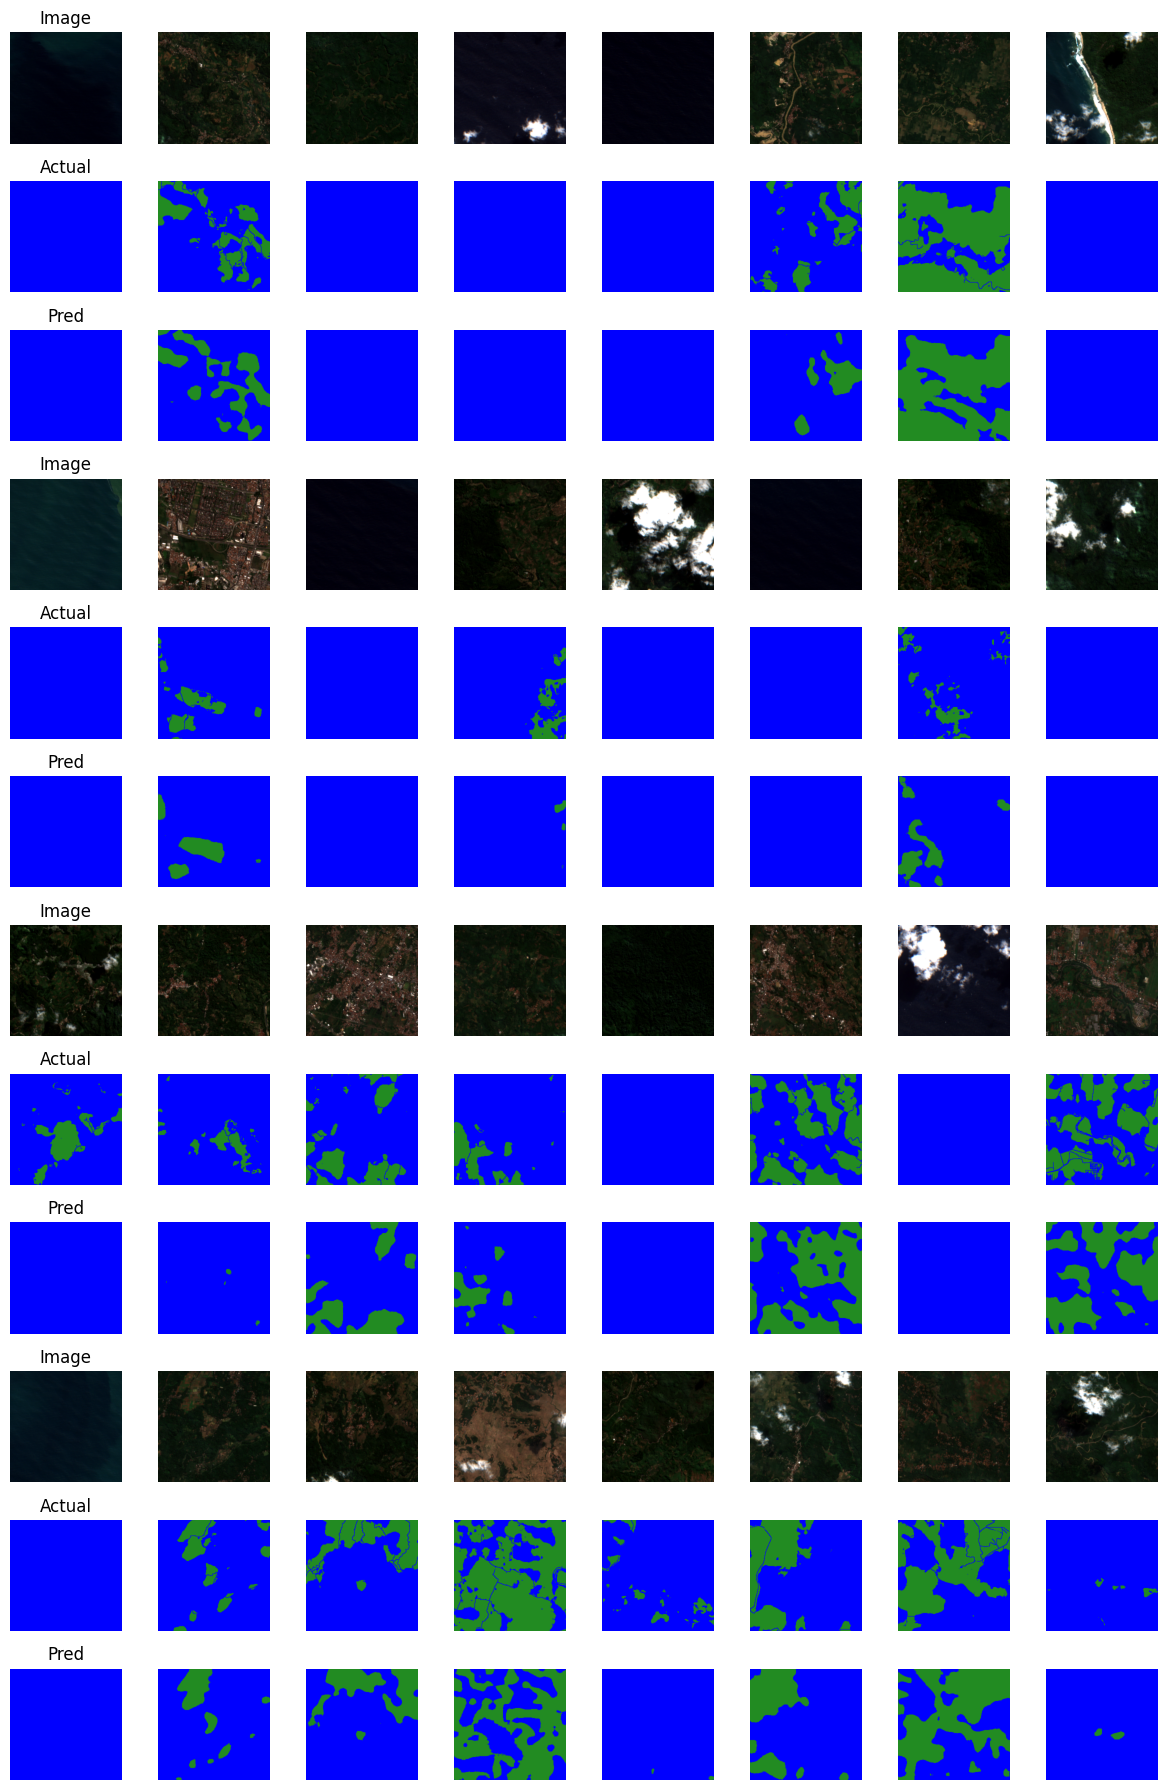

In [19]:
# Plot the predictions
plot_predictions(images, labels, preds)

In [20]:
# After Cell 17 (after run_prediction)
# CRITICAL: Inspect the actual model outputs
print("=" * 60)
print("DEBUGGING MODEL OUTPUTS")
print("=" * 60)

print(f"Outputs shape: {outputs.shape}")  # Should be [B, num_classes, H, W]
print(f"Expected: [batch_size, {NUM_CLASSES}, 256, 256]")

# Check logits for each class
for i in range(outputs.shape[1]):  # For each class
    class_logits = outputs[0, i, :, :]  # First sample, class i
    print(f"\nClass {i} logits:")
    print(f"  Min: {class_logits.min().item():.4f}")
    print(f"  Max: {class_logits.max().item():.4f}")
    print(f"  Mean: {class_logits.mean().item():.4f}")
    print(f"  Std: {class_logits.std().item():.4f}")

# Check if all classes have identical values
class_0 = outputs[0, 0, :10, :10]  # First 10x10 pixels
class_1 = outputs[0, 1, :10, :10]
print(f"\nAre class 0 and class 1 identical? {(class_0 == class_1).all().item()}")

# Check what argmax is actually selecting
preds_sample = torch.argmax(outputs[0:1], dim=1)[0]
unique_preds, counts = torch.unique(preds_sample, return_counts=True)
print(f"\nUnique predicted classes: {unique_preds.tolist()}")
print(f"Class counts: {counts.tolist()}")
print(f"Percentage class 0: {counts[0].item() / preds_sample.numel() * 100:.2f}%")

DEBUGGING MODEL OUTPUTS
Outputs shape: torch.Size([32, 2, 224, 224])
Expected: [batch_size, 2, 256, 256]

Class 0 logits:
  Min: 2.7516
  Max: 92.3505
  Mean: 28.7227
  Std: 19.0354

Class 1 logits:
  Min: -118.9873
  Max: -2.0688
  Mean: -24.2063
  Std: 18.0688

Are class 0 and class 1 identical? False

Unique predicted classes: [0]
Class counts: [50176]
Percentage class 0: 100.00%


In [21]:
# After Cell 16 or in a new cell
# Check label distribution in your dataset

import numpy as np
from pathlib import Path

train_label_dir = Path(TRAIN_LABEL_DIR)
train_files = list(train_label_dir.glob("*.npy"))  # Check first 500 labels

val_dir = Path(VAL_LABEL_DIR)
val_files = list(val_dir.glob("*.npy"))  # Check first 500 labels

def analyze_label_distribution(files):

    class_counts = {0: 0, 1: 0}
    total_pixels = 0
    all_zeros = 0  # Count chips that are entirely class 0
    has_class_1 = 0  # Count chips that have any class 1

    for label_file in files:
        label = np.load(label_file)
        unique, counts = np.unique(label, return_counts=True)
        total_pixels += label.size
        
        # Check if chip is entirely class 0
        if len(unique) == 1 and unique[0] == 0:
            all_zeros += 1
        elif 1 in unique:
            has_class_1 += 1
        
        for cls, count in zip(unique, counts):
            if cls in class_counts:
                class_counts[int(cls)] += count

    print("=" * 60)
    print("LABEL CLASS DISTRIBUTION ANALYSIS")
    print("=" * 60)
    print(f"Total chips analyzed: {len(files)}")
    print(f"Chips entirely class 0: {all_zeros} ({all_zeros/len(files)*100:.1f}%)")
    print(f"Chips with class 1: {has_class_1} ({has_class_1/len(files)*100:.1f}%)")
    print()

    for cls, count in class_counts.items():
        percentage = (count / total_pixels) * 100
        print(f"Class {cls}: {count:,} pixels ({percentage:.2f}% of all pixels)")

    print()
    print("=" * 60)
    print("IMPLICATION:")
    if all_zeros / len(files) > 0.7:
        print("⚠️  WARNING: >70% of chips are entirely class 0!")
        print("   The model can achieve high IoU by always predicting class 0.")
    elif class_counts[0] / total_pixels > 0.9:
        print("⚠️  WARNING: >90% of pixels are class 0!")
        print("   Severe class imbalance - model defaults to class 0.")
    else:
        print("Class distribution seems more balanced.")
        
analyze_label_distribution(train_files)
print('\n\n\n')
analyze_label_distribution(val_files)

LABEL CLASS DISTRIBUTION ANALYSIS
Total chips analyzed: 8603
Chips entirely class 0: 4319 (50.2%)
Chips with class 1: 4284 (49.8%)

Class 0: 360,057,857 pixels (83.41% of all pixels)
Class 1: 71,606,271 pixels (16.59% of all pixels)

IMPLICATION:
Class distribution seems more balanced.




LABEL CLASS DISTRIBUTION ANALYSIS
Total chips analyzed: 4802
Chips entirely class 0: 1204 (25.1%)
Chips with class 1: 3598 (74.9%)

Class 0: 201,479,260 pixels (83.62% of all pixels)
Class 1: 39,465,892 pixels (16.38% of all pixels)

IMPLICATION:
Class distribution seems more balanced.


[INFO] Filtered dataset: 620 / 1000 kept (62.0%). Non-empty: 492, Empty: 508, Kept 25% of empty.
After denorm: 0 255
Length of per_image_iou: 100
PER-IMAGE METRICS
Mean IoU: 0.7485
Std IoU: 0.1953
Min IoU: 0.4357
Max IoU: 1.0000

Worst 5 images (by IoU):
  Image 16: IoU=0.4357, F1=0.4656, Acc=0.8714
  Image 82: IoU=0.4493, F1=0.5505, Acc=0.7748
  Image 86: IoU=0.4564, F1=0.5250, Acc=0.8409
  Image 97: IoU=0.4610, F1=0.5110, Acc=0.8766
  Image 46: IoU=0.4625, F1=0.4805, Acc=0.9250


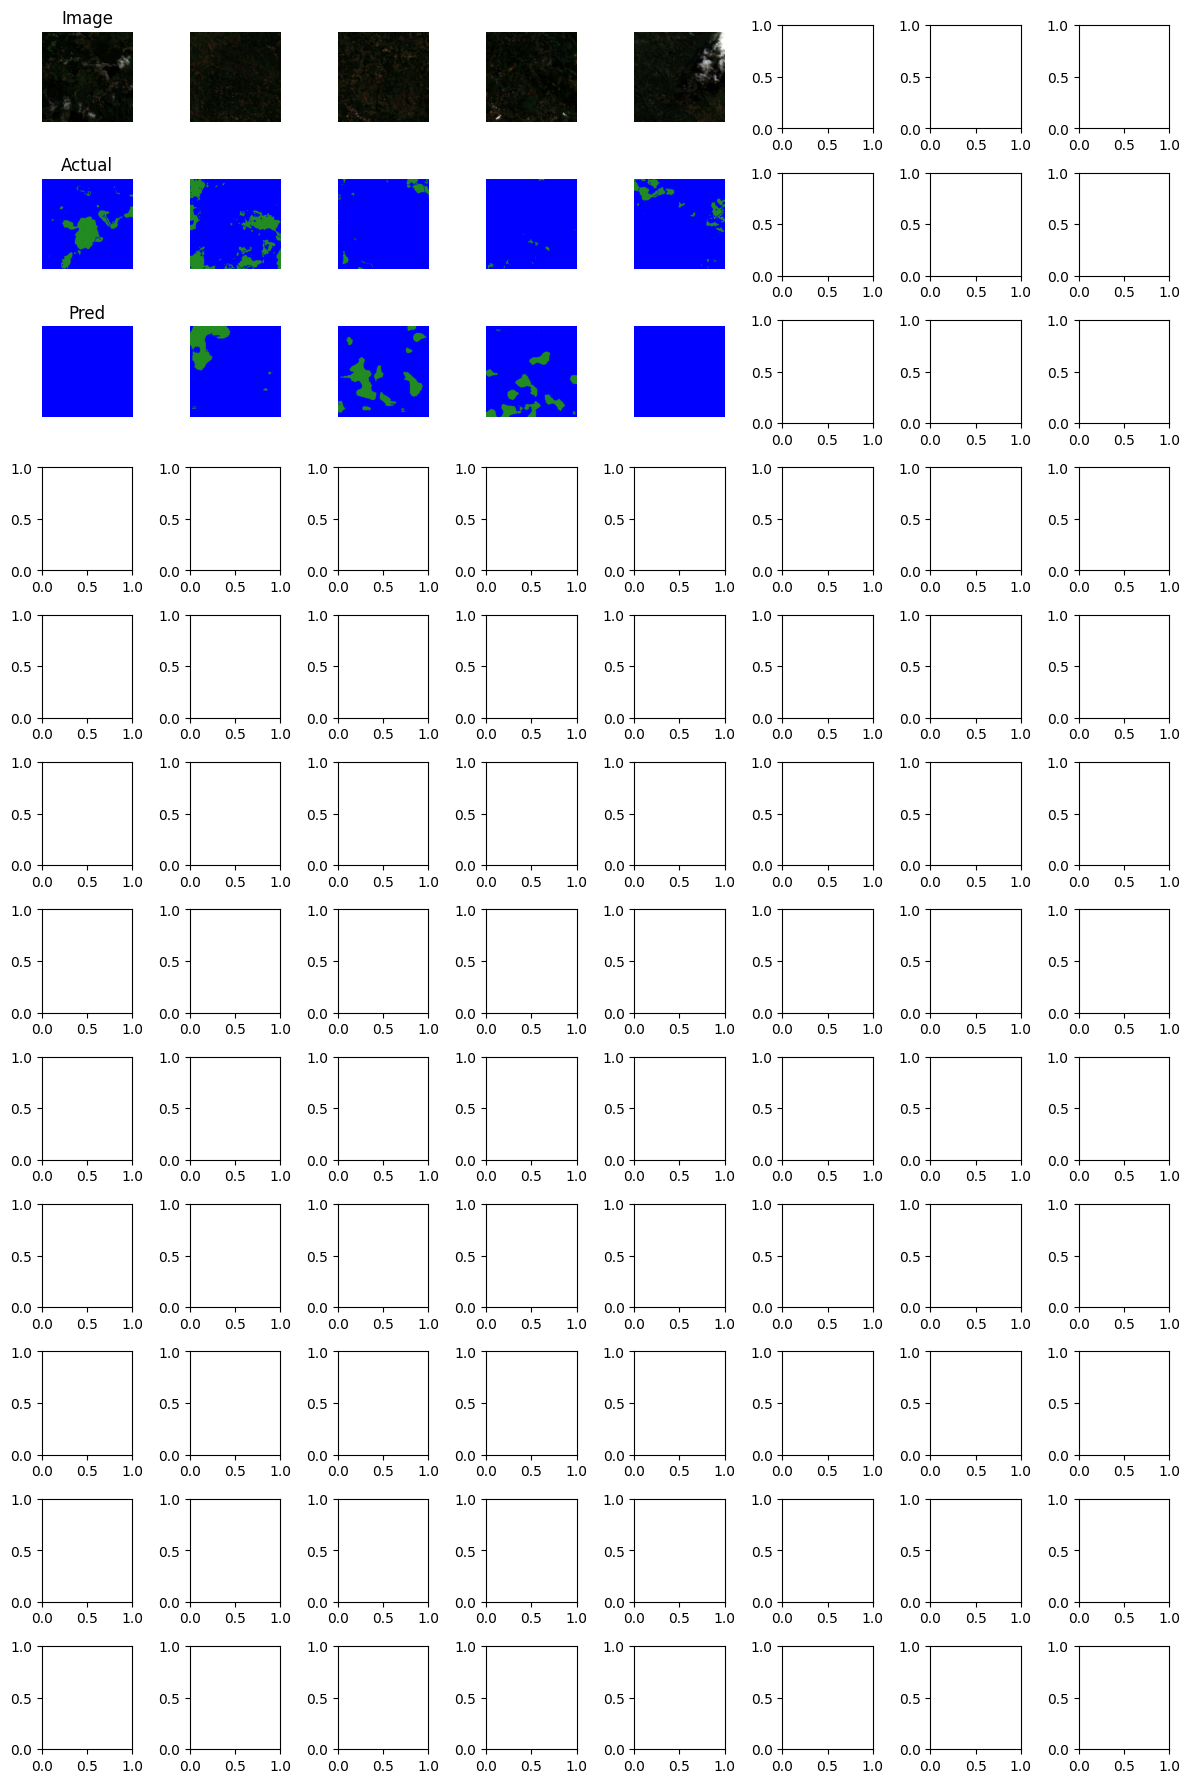

In [ ]:
# Add this cell after your existing code
# ============================================
# FAILURE ANALYSIS: Calculate per-image IoU
# ============================================

from sklearn.metrics import confusion_matrix
from torchmetrics.classification import MulticlassJaccardIndex

def calculate_per_image_metrics(outputs, labels, num_classes=2):
    """
    Calculate IoU and other metrics for each image in the batch.
    
    Returns:
        per_image_iou: List of IoU scores for each image
        per_image_f1: List of F1 scores for each image
        per_image_accuracy: List of accuracy scores for each image
    """
    batch_size = outputs.shape[0]
    per_image_iou = []
    per_image_f1 = []
    per_image_accuracy = []
    
    iou_metric = MulticlassJaccardIndex(num_classes=num_classes, average='macro').to(outputs.device)
    
    for i in range(batch_size):
        # Get predictions for this image
        pred = torch.argmax(outputs[i:i+1], dim=1)  # [1, H, W]
        label = labels[i:i+1]  # [1, H, W]
        
        # Calculate IoU
        iou = iou_metric(pred, label)
        per_image_iou.append(iou.item())
        
        # Calculate accuracy
        correct = (pred == label).sum().item()
        total = pred.numel()
        accuracy = correct / total
        per_image_accuracy.append(accuracy)
        
        # Calculate F1 (per-class then macro)
        pred_flat = pred.flatten().detach().cpu().numpy()
        label_flat = label.flatten().detach().cpu().numpy()
        
        # Per-class F1
        f1_scores = []
        for cls in range(num_classes):
            tp = ((pred_flat == cls) & (label_flat == cls)).sum()
            fp = ((pred_flat == cls) & (label_flat != cls)).sum()
            fn = ((pred_flat != cls) & (label_flat == cls)).sum()
            
            precision = tp / (tp + fp + 1e-6)
            recall = tp / (tp + fn + 1e-6)
            f1 = 2 * (precision * recall) / (precision + recall + 1e-6)
            f1_scores.append(f1)
        
        per_image_f1.append(np.mean(f1_scores))
    
    return per_image_iou, per_image_f1, per_image_accuracy


TEST_BATCH_SIZE = 100

TEST_BATCH, metadata = get_data(
    TRAIN_CHIP_DIR,
    TRAIN_LABEL_DIR,
    VAL_CHIP_DIR,
    VAL_LABEL_DIR,
    METADATA_PATH,
    TEST_BATCH_SIZE,
    NUM_WORKERS,
    PLATFORM,
    NUM_CLASSES,
)
# Move batch to GPU
test_batch = {k: v.to("cuda") for k, v in TEST_BATCH.items()}

test_output = run_prediction(model, test_batch)
test_images, test_labels, test_preds = post_process(test_batch, test_output, metadata)
# Calculate metrics for current batch
per_image_iou, per_image_f1, per_image_accuracy = calculate_per_image_metrics(
    test_output, test_batch['label'], num_classes=NUM_CLASSES
)

print(f'Length of per_image_iou: {len(per_image_iou)}')

PER-IMAGE METRICS
Mean IoU: 0.7485
Std IoU: 0.1953
Min IoU: 0.4357
Max IoU: 1.0000

Mean F1: 0.6621
Std F1: 0.1639
Min F1: 0.4656
Max F1: 0.9556

Worst 5 images (by IoU):
  Image 16: IoU=0.4357, F1=0.4656, Acc=0.8714
  Image 82: IoU=0.4493, F1=0.5505, Acc=0.7748
  Image 86: IoU=0.4564, F1=0.5250, Acc=0.8409
  Image 97: IoU=0.4610, F1=0.5110, Acc=0.8766
  Image 46: IoU=0.4625, F1=0.4805, Acc=0.9250
  Image 17: IoU=0.4734, F1=0.4985, Acc=0.9298
  Image 28: IoU=0.4742, F1=0.4947, Acc=0.9374
  Image 66: IoU=0.4810, F1=0.4903, Acc=0.9621
  Image 73: IoU=0.4811, F1=0.4904, Acc=0.9623
  Image 80: IoU=0.4852, F1=0.5465, Acc=0.8890
  Image 67: IoU=0.4869, F1=0.5078, Acc=0.9540
  Image 94: IoU=0.4916, F1=0.6096, Acc=0.7864
  Image 89: IoU=0.4934, F1=0.6517, Acc=0.6866
  Image 50: IoU=0.4957, F1=0.4978, Acc=0.9913
  Image 95: IoU=0.4981, F1=0.4990, Acc=0.9962
  Image 36: IoU=0.4985, F1=0.4992, Acc=0.9970
  Image 57: IoU=0.4986, F1=0.5204, Acc=0.9678
  Image 87: IoU=0.4991, F1=0.4995, Acc=0.9981
 

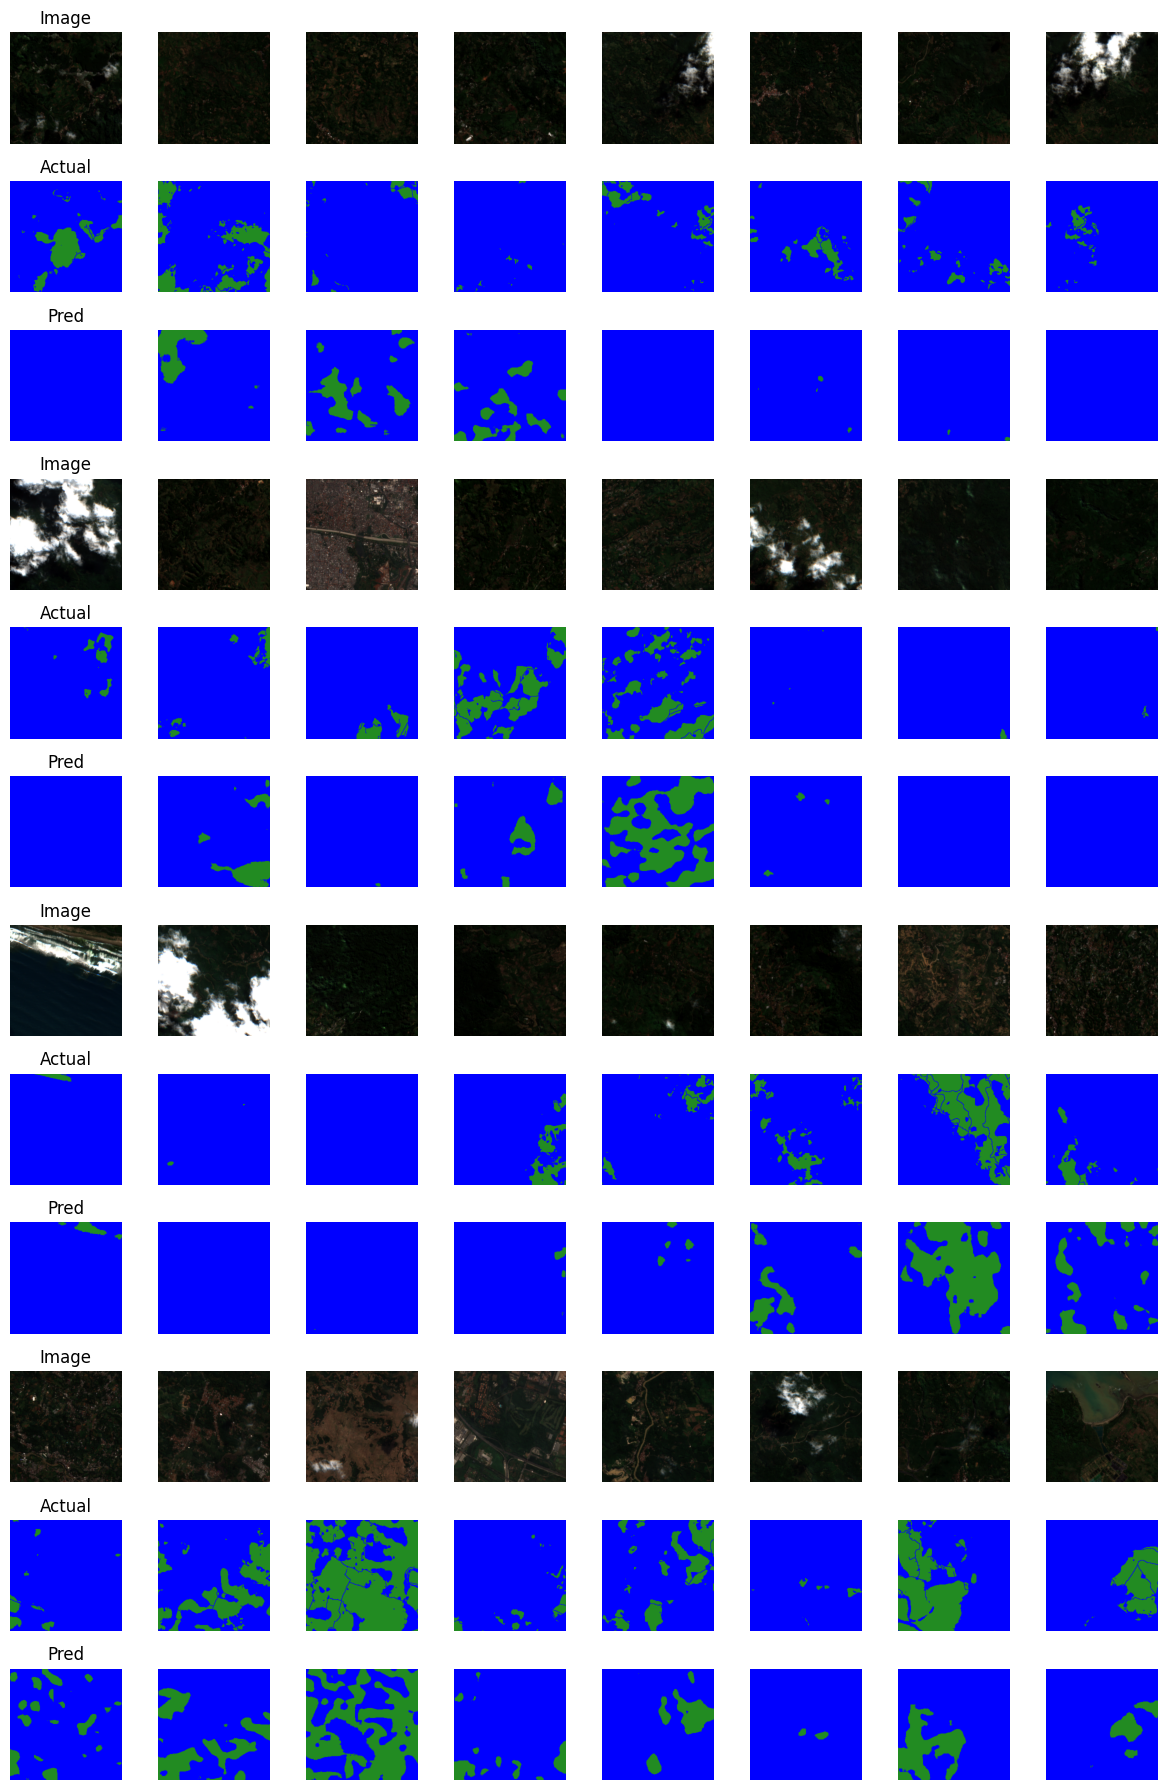

In [27]:

# Print statistics
print("=" * 60)
print("PER-IMAGE METRICS")
print("=" * 60)
print(f"Mean IoU: {np.mean(per_image_iou):.4f}")
print(f"Std IoU: {np.std(per_image_iou):.4f}")
print(f"Min IoU: {np.min(per_image_iou):.4f}")
print(f"Max IoU: {np.max(per_image_iou):.4f}")

print()

print(f"Mean F1: {np.mean(per_image_f1):.4f}")
print(f"Std F1: {np.std(per_image_f1):.4f}")
print(f"Min F1: {np.min(per_image_f1):.4f}")
print(f"Max F1: {np.max(per_image_f1):.4f}")

print(f"\nWorst 5 images (by IoU):")
worst_indices = np.argsort(per_image_iou)[:32]
worst_images = [test_images[i] for i in worst_indices]
worst_labels = [test_batch['label'][i].detach().cpu().numpy() for i in worst_indices]
worst_preds = [torch.argmax(test_output[i], dim=0).detach().cpu().numpy() for i in worst_indices]
for idx in worst_indices:
    print(f"  Image {idx}: IoU={per_image_iou[idx]:.4f}, F1={per_image_f1[idx]:.4f}, Acc={per_image_accuracy[idx]:.4f}")

    
plot_predictions(worst_images, worst_labels, worst_preds)